In [1]:
 # Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ubuntu/fastai/')
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from glob2 import glob

In [3]:
# df = pd.DataFrame(columns=["file", "species"])

# for image in glob("/home/ubuntu/plants/data/train/**/*.png"):
#     dir_name = image.split('/')
#     file_name, species = dir_name[-1], dir_name[-2]

#     df = df.append({
#         "file": file_name,
#         "species": species
#         }, ignore_index=True)
# df.species.replace('/s+','_',regex=True,inplace =True)
# df.to_csv('labels.csv', index=False)

In [4]:
files = !ls /home/ubuntu/plants/data/train | head -5

(175, 175, 3)
(140, 140, 3)
(756, 756, 3)
(350, 350, 3)
(1193, 1193, 3)


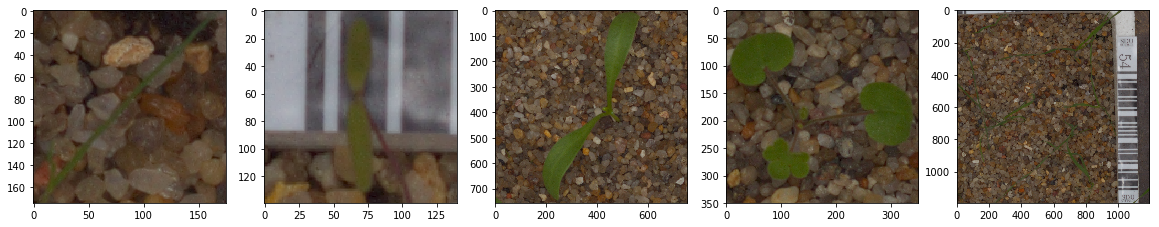

In [5]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(files):
    plt.subplot(1, columns, i + 1)
    img = plt.imread('/home/ubuntu/plants/data/train/'+image)
    plt.imshow(img)
    print(img.shape)

In [6]:
f_model = resnet34
PATH = '/home/ubuntu/plants/data/'
label_csv ='labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [7]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    val_idxs=val_idxs, test_name='test')

In [8]:
data = get_data(256)

In [9]:
learn = ConvLearner.pretrained(f_model,data)

In [10]:
learn.lr_find()

A Jupyter Widget

 93%|█████████▎| 56/60 [00:45<00:03,  1.24it/s, loss=12.4]

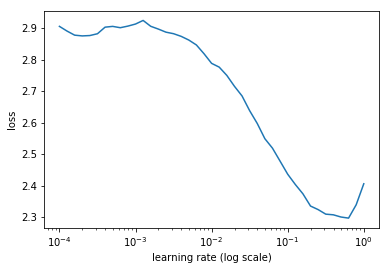

In [11]:
learn.sched.plot()

In [12]:
lr =1e-1
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError:

[ 0.       1.02815  0.72796  0.75374]                     
[ 1.       1.11791  0.62668  0.787  ]                     
[ 2.       0.89962  0.51471  0.81493]                      
[ 3.       0.82903  0.57503  0.80478]                      
[ 4.       0.73943  0.4879   0.82971]                      
[ 5.       0.62436  0.41043  0.87091]                      
[ 6.       0.55147  0.40107  0.86759]                      



In [13]:
lrs =np.array([1e-4,1e-3,1e-2])
learn.unfreeze()
learn.fit(lrs,n_cycle=3,cycle_len=1,cycle_mult=2)

A Jupyter Widget

[ 0.       0.42443  0.31462  0.88738]                      
[ 1.       0.37516  0.22111  0.91258]                      
[ 2.       0.27753  0.20765  0.91674]                      
[ 3.       0.23086  0.20133  0.93133]                      
[ 4.       0.18904  0.1858   0.93881]                      
[ 5.       0.15911  0.18314  0.93881]                      
[ 6.       0.14323  0.18047  0.94109]                      



In [14]:
pred,y = learn.TTA()

In [15]:
accuracy(pred,y)

0.93789473684210523

In [16]:
submission, test_y = learn.TTA(is_test=True)

In [17]:
submission = np.argmax(np.exp(submission),axis=1)

In [18]:
func = np.vectorize(lambda x:data.classes[x])
species = func(submission)

In [19]:
test_df = [f.split('/')[1] for f in data.test_dl.dataset.fnames]
test_df[:5]

['12625488b.png',
 'c832e4302.png',
 'e82017baa.png',
 'c10ccbd82.png',
 '8b27bfd2b.png']

In [20]:
len(species) == len(test_df)

True

In [21]:
submission_df = pd.DataFrame({'file': test_df, 'species': species})
submission_df.to_csv('submission.csv.gz', compression = 'gzip',index=False)